### Data 620 - Project 2
### Leticia Salazar
### March 5, 2023

#### Task:

1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

#### Data source:

We decided to continue working with our project 1 dataset since it's a 2 node network to further explore the dataset and be able to create better visualizations. This dataset was obtained from [Network Repository](https://networkrepository.com/socfb-Cornell5.php) consisting of people (nodes) and their friendship ties (edges) on Facebook. The data is available in a matrix market, typically a sparse format used to represent a matrix (.mtx file). With these types of files, the first line contains a header with information about the matrix, dimensions, and symmetry of the matrix. The following lines are non-zero entries of the matrix in row-major order, with each following line containing the row index, column index, and a value of a single non-zero entry.

Below are some specs from this dataset provided by the repository:

* Nodes: 18.7K
* Edges: 790.8K
* Density: 0.00454239
* Maximum degree: 3.2K
* Minimum degree: 1
* Average degree: 84
* Assortativity: 0.01805
* Number of triangles: 18.3M
* Average number of triangles: 982
* Maximum number of triangles: 77.2K
* Average clustering coefficient: 0.219051
* Fraction of closed triangles: 0.135615
* Maximum k-core: 85
* Lower bound of Maximum Clique: 13

#### Load libraries:

Below are the libraries used

In [34]:
# data manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm #Instantly make your loops show a smart progress meter 
import random 
from scipy import stats
import csv
import math

# data visualization
import networkx as nx
import matplotlib.pyplot as plt
from networkx_viewer import Viewer
from pyvis.network import Network # interactive graph

# Import bi-partite (bi-modal) functions
from networkx.algorithms import bipartite as bi
import networkx as net

##### Load the data:
As mentioned, the original file is too large and had to be split to contain 5000 variables only.

In [2]:
# load 2 mode network 
df = pd.read_csv('fb_split.csv')
df

,Person,Friendships
0,184,1
1,344,1
2,635,1
3,867,1
4,1296,1
...,...,...
4995,13909,67
4996,13940,67
4997,14294,67
4998,14361,67


In [3]:
df.shape

(5000, 2)

With our data we have 4,085 unique person's so we know there are a couple of people that are duplicated or have multiple connections.

In [4]:
df.Person.nunique()

4085

In [5]:
df.Person.value_counts()

17027    11
8201      7
16112     7
12797     7
9651      6
         ..
12168     1
12406     1
12933     1
13305     1
13940     1
Name: Person, Length: 4085, dtype: int64

The following code was obtained from a YouTube video in which we use the loaded csv file to create our networkx graph

In [6]:
# defining the list of nodes from our columns
person = list(df['Person'])
friendships = list(df['Friendships'])

In [7]:
# Since we have a repeated elements since this is an edgelist we have
# ensure that we extract the set of our columns
set_person = set(person)
set_friendships = set(friendships)

In [8]:
# checking how many person's and frienships we have in our data set
# note: that we have 4085 unique values now
print("The number of person's = ", len(set_person))
print("The number of frienships' = ", len(set_friendships))

The number of person's =  4085
The number of frienships' =  67


#### Start creating the network

In [9]:
# top and bottom references the list of person's (top) and friendships (bottom)
def create_from_edgelist(top,bottom): 
    
    # creating graph
    B = nx.Graph()
    
    # iterating through each row since each one is an edge 
    for i in range(len(top)):
        B.add_node(top[i], bipartite=0)
        B.add_node(bottom[i], bipartite=1)
        B.add_edge(top[i], bottom[i])
    return B

# assign the list we created in cell 7
B = create_from_edgelist(person,friendships)

print("The number of nodes = ", len(B.nodes))
print("The number of edges = ", len(B.edges))

The number of nodes =  4147
The number of edges =  5000


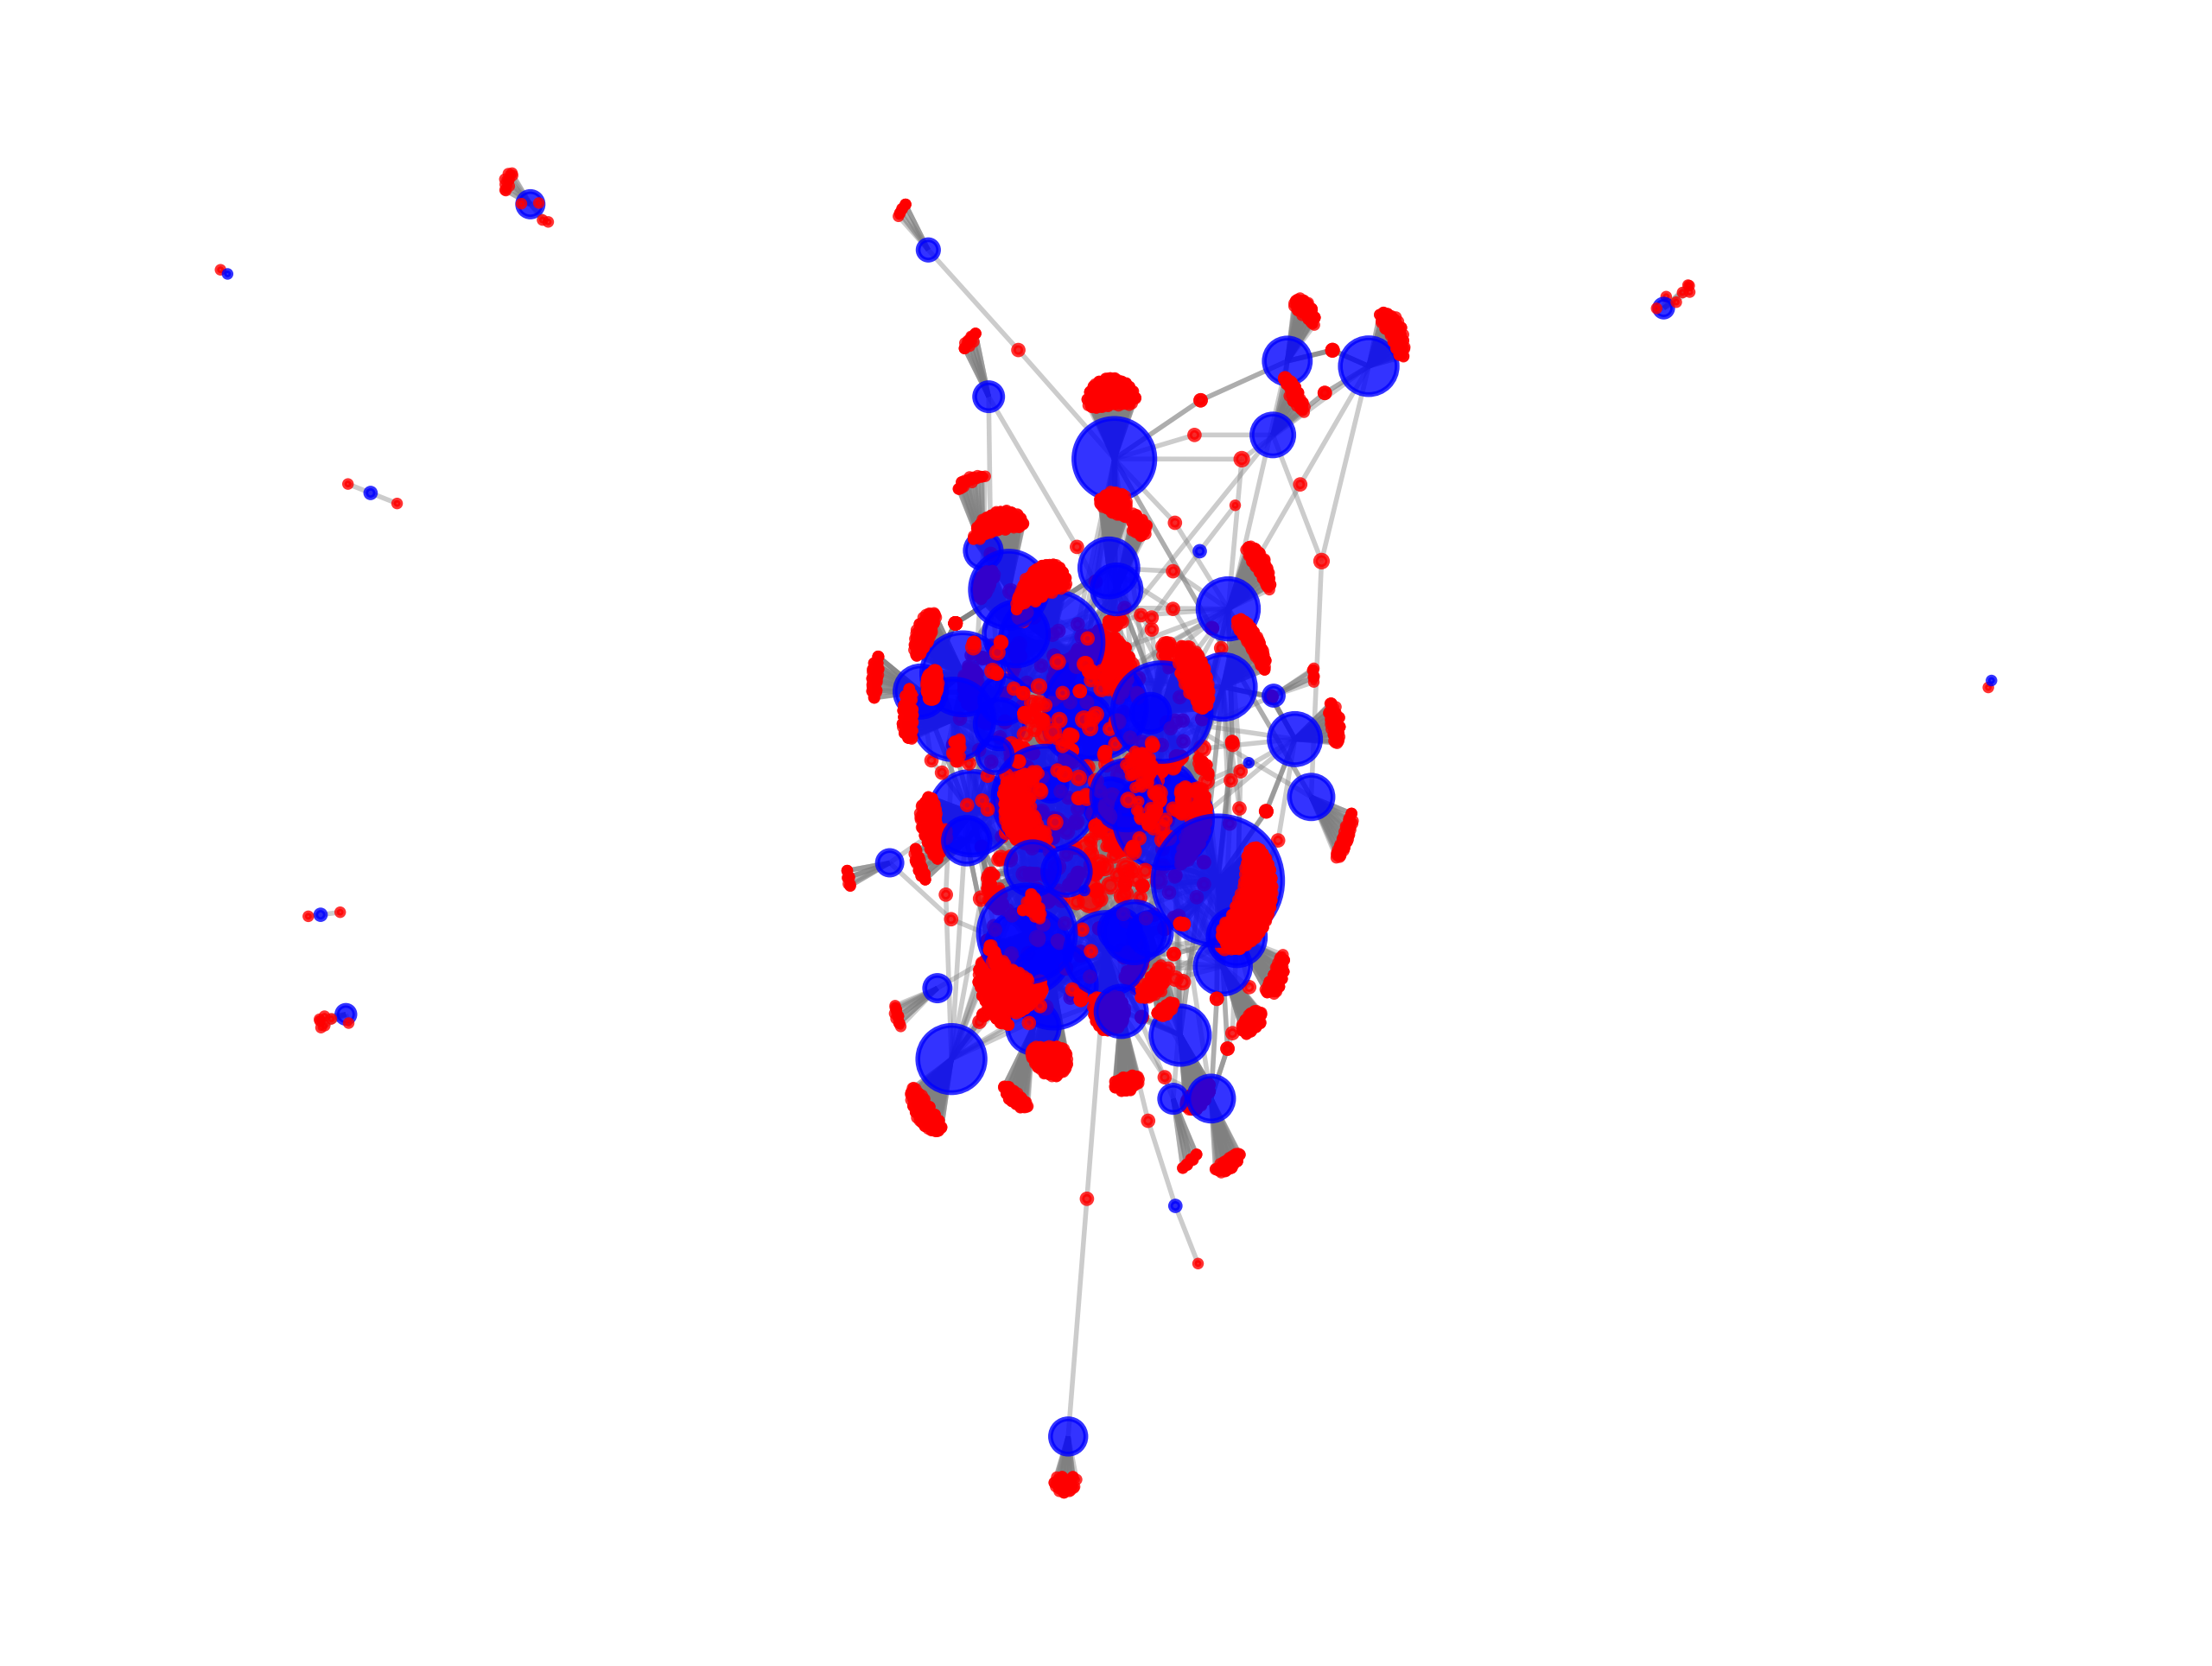

In [10]:
# Creating environment for figure
f = plt.figure(1,figsize=(8,6), dpi=400)

# defining layout
pos = nx.spring_layout(B)

colors = {0:'r', 1:'b'}

# defining nodes
nx.draw_networkx_nodes(B, pos=pos, \
                      node_size=[B.degree[node]*2 for node in B], \
                      alpha=0.8, \
                      node_color=[colors[B.nodes[node]['bipartite']] for node in B])

# definging the edges
nx.draw_networkx_edges(B, pos=pos, alpha=0.4, \
                      edge_color = 'gray')

plt.axis('off')
plt.show()

Since we have a lot of connections it's hard to visualize the graph, so we created an interactive graph using Pyvis and the results are below:

In [11]:
# create vis network
net = Network(notebook=True)
# load the networkx graph
net.from_nx(B)
# show
net.show("graph1.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


#### Island Method

The following code was taken from SNAS Chapter 4 to perform the island method which is used to analyze networks. 

In [17]:
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight=edata['weight'])
    return g2

def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [20]:
person_weighted = bi.weighted_projected_graph(B, set_person, ratio=False)
friendships_weighted = bi.weighted_projected_graph(B, set_friendships, ratio=False)

In [21]:
person_thresholds = island_method(person_weighted)

In [28]:
print("threshold level, size of graph, # of connected compoents")
for i in person_thresholds:
    print(i[0], "\t\t", len(i[1]),"\t\t", len(list(B.subgraph(c) for c in nx.connected_components(i[1]))))

threshold level, size of graph, # of connected compoents
1 		 667 		 42
11 		 10 		 3
21 		 6 		 2
31 		 5 		 2
41 		 2 		 1
51 		 2 		 1


In [40]:
friendships_thresholds = island_method(friendships_weighted)

In [41]:
print("threshold level, size of graph, # of connected compoents")
for i in friendships_thresholds:
    print(i[0], "\t\t", len(i[1]),"\t\t", len(list(B.subgraph(c) for c in nx.connected_components(i[1]))))

threshold level, size of graph, # of connected compoents
1 		 64 		 1
11 		 13 		 3
21 		 6 		 2
31 		 5 		 2
41 		 2 		 1
51 		 2 		 1


#### References:

* Mayank, M. (2021, February 1). Visualizing Networks in python. Medium. Retrieved March 10, 2023, from https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259 
* YouTube. (2021, July 8). Analysis of two-mode networks with Python | Demival vasques filho. YouTube. Retrieved March 10, 2023, from https://www.youtube.com/watch?v=CcOfX4n4pWg 
* Network Analysis in Python: Projected_graph. projected_graph - NetworkX 3.0 documentation. (n.d.). Retrieved March 10, 2023, from https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.projection.projected_graph.html 